# 训练预测

### toc
- [加载库](#加载库)
- [加载数据](#加载数据)
- [探索特征](#探索特征)
- [特征转换](#特征转换)
- [模型训练评估](#模型训练评估)
- [预测结果展示](#预测结果展示)



# 加载库

In [39]:
%pylab
%matplotlib inline
import pandas as pd
import sklearn.linear_model as lm
import sklearn.tree as tree
import sklearn.neural_network as nn
import sklearn.ensemble as es
import sklearn.kernel_ridge as kr
import sklearn.metrics as mt
import sklearn.cross_validation as cv
import sklearn.preprocessing as pp
pd.options.display.max_columns = 100
pd.options.display.max_rows = 20



Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


# 加载数据

In [40]:
df = pd.read_csv("data/train.csv",sep=",",header=0,parse_dates=[0])
df.dtypes

df["hour"]=df.apply(lambda x:x["datetime"].hour,axis=1)
df["weekday"]=df.apply(lambda x:x["datetime"].weekday(),axis=1)
df["month"]=df.apply(lambda x:x["datetime"].month,axis=1)
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,weekday,month
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,11.541613,3.013963,6.521495
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,6.915838,2.004585,3.444373
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,6.000000,1.000000,4.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,12.000000,3.000000,7.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,18.000000,5.000000,10.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,23.000000,6.000000,12.000000


# 探索特征

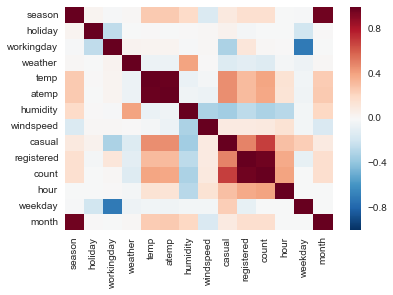

In [41]:
#探索特征
#train.plot(x = 'datetime', y ='count')
import pylab as plt
import seaborn as sns
sns.heatmap(df.corr())

In [42]:
scaler = pp.StandardScaler().fit(df.select(lambda x:x != "datetime",axis=1))
scaler.mean_

array([  2.50661400e+00,   2.85688040e-02,   6.80874518e-01,
         1.41842734e+00,   2.02308598e+01,   2.36550841e+01,
         6.18864597e+01,   1.27993954e+01,   3.60219548e+01,
         1.55552177e+02,   1.91574132e+02,   1.15416131e+01,
         3.01396289e+00,   6.52149550e+00])

# 特征转换

In [43]:
#特征转换
def replace_mean_target(df,col_name,target_name,new_col_name):
    grouped=df[[col_name,target_name]].groupby(col_name)
    mean_count_dict=grouped.aggregate(np.mean)[target_name].to_dict()
    df[new_col_name] = df.apply(lambda x:mean_count_dict[x[col_name]],axis=1)
    return mean_count_dict
    
def replace_idx(df,col_name,new_col_name):    
    keys_list = df[col_name].value_counts().keys()
    keys_idx_dict = {kk:kk_idx for kk,kk_idx in zip(keys_list,range(0,len(keys_list)))}
    df[new_col_name] = df.apply(lambda x:keys_idx_dict[x[col_name]],axis=1)
    return keys_idx_dict

def discretize(df,col):
    for idx in df[col].value_counts().index:
        new_col_name = col+"__"+str(idx)
        df[new_col_name] = df[col].apply(lambda x:1 if(x==idx) else 0)
#         df[col+"__"+idx] = df[[col]].apply(lambda x:1 if(x==idx) else 0,axis=1)

#series不需要axis


df["hour_workingday"]=df.apply(lambda x:str(x["hour"])+"_"+str(x["workingday"]),axis=1)
print(replace_idx(df,"hour_workingday","hour_workingday_idx"))
df["hour_holiday"]=df.apply(lambda x:str(x["hour"])+"_"+str(x["holiday"]),axis=1)
print(replace_idx(df,"hour_holiday","hour_holiday_idx"))

df["hour_weekday"]=df.apply(lambda x:str(x["hour"])+"_"+str(x["weekday"]),axis=1)
print(replace_idx(df,"hour_weekday","hour_weekday_idx"))

# df["hour_month"]=df.apply(lambda x:str(x["hour"])+"_"+str(x["month"]),axis=1)
# print(replace_idx(df,"hour_month","hour_month_idx"))

replace_mean_target(df,"hour","count","hour_lookup_count")
replace_mean_target(df,"hour_workingday_idx","count","hour_workingday_idx_count")
replace_mean_target(df,"hour_holiday_idx","count","hour_holiday_idx_count")
replace_mean_target(df,"hour_weekday_idx","count","hour_weekday_idx_count")
# replace_mean_target(df,"hour_month_idx","count","hour_month_idx_count")


# df["count_log"] = np.log(df["count"]+1)
df["hour_holiday_idx_count_log"] = np.log(df["hour_holiday_idx_count"]+1)
df["hour_workingday_idx_count"] = np.log(df["hour_workingday_idx_count"]+1)
# df["hour_month_idx_count"] = np.log(df["hour_month_idx_count"]+1)


discretize(df,"hour")
df["temp_int"] = df["temp"].apply(lambda x:int(x))
discretize(df,"temp_int")

df = df[df.humidity>17]

{'12_0': 34, '12_1': 6, '8_1': 13, '6_1': 12, '13_1': 0, '13_0': 40, '21_0': 26, '21_1': 7, '17_0': 42, '11_0': 41, '5_0': 47, '18_0': 32, '1_1': 20, '10_1': 14, '1_0': 37, '6_0': 24, '9_0': 25, '7_1': 17, '7_0': 44, '11_1': 15, '0_1': 18, '3_1': 23, '3_0': 45, '16_0': 36, '16_1': 10, '2_0': 46, '2_1': 21, '17_1': 11, '5_1': 19, '9_1': 16, '18_1': 4, '15_1': 9, '15_0': 43, '0_0': 30, '4_0': 39, '4_1': 22, '14_0': 33, '14_1': 2, '19_1': 1, '19_0': 31, '23_0': 28, '23_1': 3, '22_1': 5, '22_0': 29, '20_1': 8, '20_0': 27, '10_0': 35, '8_0': 38}
{'12_0': 3, '6_1': 34, '6_0': 15, '8_0': 12, '12_1': 46, '13_1': 40, '13_0': 11, '21_0': 0, '21_1': 24, '5_0': 20, '10_1': 36, '9_1': 31, '10_0': 18, '1_0': 19, '18_1': 30, '7_1': 32, '7_0': 17, '0_0': 13, '11_0': 14, '3_1': 47, '3_0': 23, '16_0': 10, '16_1': 25, '2_0': 21, '2_1': 42, '17_1': 35, '17_0': 9, '18_0': 5, '9_0': 16, '15_1': 33, '15_0': 7, '11_1': 37, '4_0': 22, '0_1': 26, '14_0': 6, '14_1': 44, '19_1': 41, '19_0': 8, '4_1': 28, '23_0': 

# 模型训练评估

In [44]:
traindf = df.copy()
p=traindf.select(lambda x: x not in ["datetime","casual","registered","hour_workingday","hour_holiday","hour_weekday"] ,
                 axis=1)
p.sample(10)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,weekday,month,hour_workingday_idx,hour_holiday_idx,hour_weekday_idx,hour_lookup_count,hour_workingday_idx_count,hour_holiday_idx_count,hour_weekday_idx_count,hour_holiday_idx_count_log,hour__23,hour__20,hour__16,hour__17,hour__18,hour__15,hour__12,hour__19,hour__13,hour__21,hour__14,hour__22,hour__6,hour__11,hour__10,hour__9,hour__7,hour__8,hour__0,hour__1,hour__5,hour__2,hour__4,hour__3,temp_int,temp_int__22,temp_int__13,temp_int__18,temp_int__27,temp_int__9,temp_int__14,temp_int__26,temp_int__28,temp_int__25,temp_int__16,temp_int__24,temp_int__12,temp_int__21,temp_int__17,temp_int__29,temp_int__31,temp_int__10,temp_int__20,temp_int__30,temp_int__15,temp_int__8,temp_int__23,temp_int__32,temp_int__11,temp_int__19,temp_int__6,temp_int__33,temp_int__5,temp_int__7,temp_int__4,temp_int__34,temp_int__35,temp_int__36,temp_int__37,temp_int__3,temp_int__0,temp_int__38,temp_int__39,temp_int__2,temp_int__1,temp_int__41
7343,2,0,0,1,23.78,27.275,83,6.0032,197,8,5,5,38,12,10,362.769231,4.729643,366.703620,117.560606,5.907277,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
509,1,0,1,2,6.56,9.090,80,8.9981,127,9,4,2,16,16,128,221.780220,5.494269,222.088235,262.406250,5.407567,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9003,3,0,1,1,33.62,12.120,41,15.0013,365,12,4,8,6,3,138,256.508772,5.300052,254.693002,236.359375,5.543978,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9719,4,0,1,2,17.22,21.210,80,12.9980,713,8,1,10,13,12,147,362.769231,6.175753,366.703620,469.171875,5.907277,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1726,2,0,0,1,21.32,25.000,36,12.9980,141,20,6,4,27,4,24,228.517544,5.219311,228.792325,172.590909,5.437176,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5438,1,0,0,2,18.04,21.970,54,19.9995,215,16,6,1,36,10,6,316.372807,5.909843,316.417607,365.530303,5.760218,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5584,1,0,0,1,21.32,25.000,42,7.0015,215,19,5,1,31,8,12,315.278509,5.494479,316.306998,249.969697,5.759870,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
520,1,0,1,2,9.84,12.120,65,11.0014,71,20,4,2,8,4,129,228.517544,5.522913,228.792325,216.796875,5.437176,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9565,4,0,1,2,25.42,27.275,94,7.0015,240,22,1,10,5,2,68,133.576754,4.936946,133.347630,130.630769,4.900431,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10220,4,0,0,1,12.30,15.910,87,6.0032,19,6,6,11,24,15,29,76.259341,3.044194,77.357466,15.136364,4.361281,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [45]:
p.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,weekday,month,hour_workingday_idx,hour_holiday_idx,hour_weekday_idx,hour_lookup_count,hour_workingday_idx_count,hour_holiday_idx_count,hour_weekday_idx_count,hour_holiday_idx_count_log,hour__23,hour__20,hour__16,hour__17,hour__18,hour__15,hour__12,hour__19,hour__13,hour__21,hour__14,hour__22,hour__6,hour__11,hour__10,hour__9,hour__7,hour__8,hour__0,hour__1,hour__5,hour__2,hour__4,hour__3,temp_int,temp_int__22,temp_int__13,temp_int__18,temp_int__27,temp_int__9,temp_int__14,temp_int__26,temp_int__28,temp_int__25,temp_int__16,temp_int__24,temp_int__12,temp_int__21,temp_int__17,temp_int__29,temp_int__31,temp_int__10,temp_int__20,temp_int__30,temp_int__15,temp_int__8,temp_int__23,temp_int__32,temp_int__11,temp_int__19,temp_int__6,temp_int__33,temp_int__5,temp_int__7,temp_int__4,temp_int__34,temp_int__35,temp_int__36,temp_int__37,temp_int__3,temp_int__0,temp_int__38,temp_int__39,temp_int__2,temp_int__1,temp_int__41
count,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.00000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000
mean,2.512269,0.028690,0.681181,1.416328,20.240913,23.664194,62.115775,12.752879,191.980443,11.541236,3.010793,6.536808,19.100092,12.136900,82.817712,191.540343,4.743572,191.540007,191.485040,4.832531,0.041882,0.041974,0.041697,0.041882,0.041974,0.041790,0.041974,0.041882,0.041882,0.041974,0.041790,0.041882,0.041790,0.041790,0.041790,0.041790,0.041790,0.041790,0.041790,0.041697,0.041513,0.041144,0.040683,0.039852,19.750277,0.073432,0.070480,0.066605,0.057011,0.050000,0.042712,0.041790,0.039391,0.036993,0.036255,0.035886,0.035517,0.033303,0.032288,0.032565,0.031365,0.030627,0.030166,0.027583,0.023155,0.021125,0.018727,0.018635,0.016697,0.01559,0.013469,0.011900,0.009871,0.009779,0.009594,0.007380,0.007011,0.006365,0.003137,0.001015,0.000646,0.000646,0.000554,0.000461,0.000185,0.000092
std,1.114547,0.166942,0.466040,0.631179,7.802934,8.487656,18.953806,8.117775,181.152796,6.917005,2.006718,3.442264,13.155785,7.984178,48.379975,130.223377,1.264439,130.565444,146.678584,1.137954,0.200329,0.200539,0.199906,0.200329,0.200539,0.200117,0.200539,0.200329,0.200329,0.200539,0.200117,0.200329,0.200117,0.200117,0.200117,0.200117,0.200117,0.200117,0.200117,0.199906,0.199482,0.198632,0.197563,0.195621,7.803360,0.260856,0.255966,0.249348,0.231874,0.217955,0.202217,0.200117,0.194533,0.188752,0.186932,0.186014,0.185090,0.179434,0.176772,0.177502,0.174311,0.172314,0.171052,0.163782,0.150403,0.143809,0.135565,0.135237,0.128141,0.12389,0.115276,0.108443,0.098865,0.098407,0.097483,0.085594,0.083442,0.079532,0.055919,0.031841,0.025405,0.025405,0.023521,0.021473,0.013583,0.009605
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.760000,18.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,6.407240,1.773720,6.377622,4.034483,1.998451,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

In [6]:
kfs = cv.KFold(p.index.size,n_folds=5)
def split(p,kfs,target_col_name):
    for train_index,test_index in kfs:
        train_data = p.iloc[train_index]
        test_data = p.iloc[test_index]
        train_data_features=train_data.select(lambda x:x != target_col_name,axis=1)#.as_matrix()
        train_data_target=train_data[target_col_name]#.as_matrix()
        test_data_features=test_data.select(lambda x:x != target_col_name,axis=1)#.as_matrix()
        test_data_target=test_data[target_col_name]#.as_matrix()
        yield (train_data_features,train_data_target,test_data_features,test_data_target)
total_train_data_features=p.select(lambda x:x not in ["count","count_log" ],axis=1)#.as_matrix()
total_train_data_target=p["count"]#.as_matrix()

In [7]:
models = {
#           "lr":lm.LinearRegression(fit_intercept=True),
#           "ridge":lm.Ridge(),
          "dtree":tree.DecisionTreeRegressor(max_depth=10),
          "rf":es.RandomForestRegressor(n_estimators=100,max_depth=7),
          "bag":es.BaggingRegressor(n_estimators=50),
          "gb":es.GradientBoostingRegressor(n_estimators=100),
#           kr.KernelRidge()
         }

# for (modelname,model) in models.items():
modelname = "rf"
model=es.RandomForestRegressor(n_estimators=100,max_depth=7)
score = []
for train_data_features,train_data_target,test_data_features,test_data_target in split(p,kfs,"count"):
    scaler = pp.StandardScaler().fit(train_data_features)
#     train_data_features = scaler.transform(train_data_features)
#     test_data_features = scaler.transform(test_data_features)    
    model.fit(train_data_features,train_data_target)
    #print train_data_features.columns
    hh = zip(model.predict(test_data_features),test_data_target.as_matrix())
    evaluation = sqrt(mean(map(lambda x:(log(x[0]+1)-log(x[1]+1))**2,hh)))
#     evaluation = sqrt(mean(map(lambda x:(x[0]-x[1])**2,hh)))
    score.append((modelname,
        evaluation,
        model.score(test_data_features,test_data_target),
        mt.mean_absolute_error(test_data_target,model.predict(test_data_features))
        ))
print(modelname,mean(map(lambda x:x[1],score)),std(map(lambda x:x[1],score)) )

('rf', 0.56710591199565918, 0.14097500875615859)


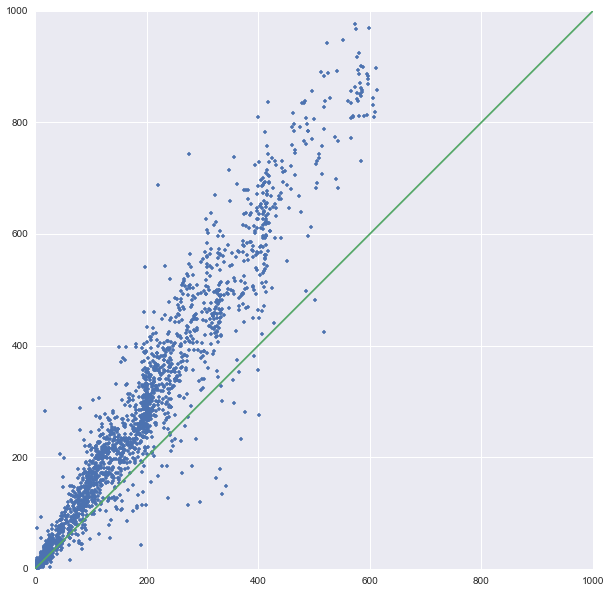

In [8]:
plt.figure(figsize=(10,10))
plt.plot(model.predict(test_data_features),test_data_target.as_matrix(),".")
plt.plot([0,1000],[0,1000])

In [9]:
hh[0:10]

[(403.40706095312242, 526),
 (401.89230397607434, 450),
 (407.21660548321233, 421),
 (392.18378679700641, 382),
 (262.05704534952196, 229),
 (280.88519444243974, 185),
 (189.62655229858291, 193),
 (175.55908937133802, 208),
 (140.31257355860404, 157),
 (89.786749527442723, 87)]

In [10]:
# df = df[df.humidity<20]
# df.reindex()

# 预测结果展示

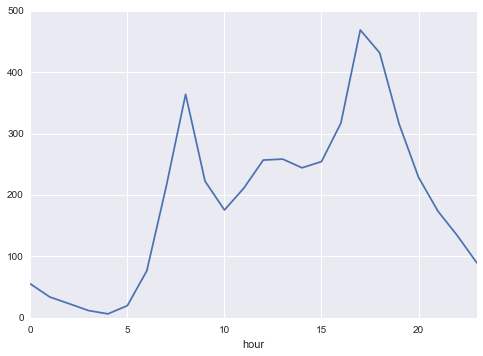

In [11]:
df.groupby(["hour"]).aggregate(np.mean)["count"].plot()

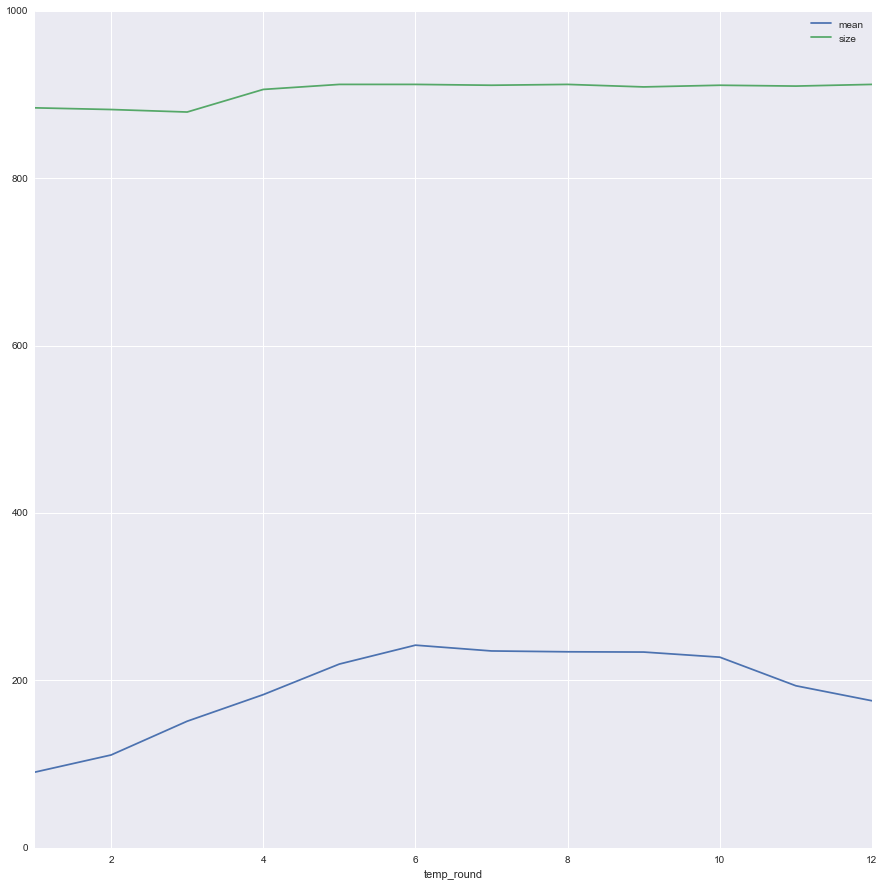

In [12]:
tmpdf = df.copy()
tmpdf["temp_round"] = np.round(tmpdf["month"],decimals=0)
tmpdf.groupby(["temp_round"])["count"].aggregate([np.mean,np.size]).plot(figsize=(15,15))

In [15]:
df.head(20)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,temp_int__35,temp_int__36,temp_int__37,temp_int__3,temp_int__0,temp_int__38,temp_int__39,temp_int__2,temp_int__1,temp_int__41
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,...,0,0,0,0,0,0,0,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,...,0,0,0,0,0,0,0,0,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,...,0,0,0,0,0,0,0,0,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,...,0,0,0,0,0,0,0,0,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,...,0,0,0,0,0,0,0,0,0,0
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,...,0,0,0,0,0,0,0,0,0,0
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,...,0,0,0,0,0,0,0,0,0,0
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,...,0,0,0,0,0,0,0,0,0,0
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,...,0,0,0,0,0,0,0,0,0,0
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,8,...,0,0,0,0,0,0,0,0,0,0
